# Ecommerce Shipping Analysis pipeline

### **Overview**
This notebook combines **Exploratory Data Analysis (EDA)**, **Preprocessing**, **Model Training**, and **Evaluation** into a single, streamlined pipeline.  
It allows us to:
- Explore and understand the dataset

- Clean and preprocess the data
- Train multiple machine learning models
- Evaluate and select the best performing model
- Save the trained model for backend deployment

**Dataset:** [Customer Analytics – E‑Commerce Shipping Data on Kaggle](https://www.kaggle.com/datasets/prachi13/customer-analytics/data)

## Import Libraries
We start by importing all the necessary libraries for:
- Data handling: `pandas`, `numpy`

- Visualization: `matplotlib`, `seaborn`
- Machine Learning: `scikit-learn`, `xgboost`
- Model saving/loading: `joblib`


In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.model_selection import learning_curve
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

import joblib
import os
from datetime import datetime

### Load Raw Data
We load the dataset from the `data/raw` directory.


In [43]:
raw_path = "../data/raw/train.csv"
df = pd.read_csv(raw_path)
df.head()

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,1,D,Flight,4,2,177,3,low,F,44,1233,1
1,2,F,Flight,4,5,216,2,low,M,59,3088,1
2,3,A,Flight,2,2,183,4,low,M,48,3374,1
3,4,B,Flight,3,3,176,4,medium,M,10,1177,1
4,5,C,Flight,2,2,184,3,medium,F,46,2484,1


### Exploratory Data Analysis
In this section, we:

- Inspect data structure

- Check missing values
- Visualize target distribution
- Visualize numerical feature distributions
- Generate a correlation heatmap

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   10999 non-null  int64 
 1   Warehouse_block      10999 non-null  object
 2   Mode_of_Shipment     10999 non-null  object
 3   Customer_care_calls  10999 non-null  int64 
 4   Customer_rating      10999 non-null  int64 
 5   Cost_of_the_Product  10999 non-null  int64 
 6   Prior_purchases      10999 non-null  int64 
 7   Product_importance   10999 non-null  object
 8   Gender               10999 non-null  object
 9   Discount_offered     10999 non-null  int64 
 10  Weight_in_gms        10999 non-null  int64 
 11  Reached.on.Time_Y.N  10999 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 1.0+ MB
None
ID                     0
Warehouse_block        0
Mode_of_Shipment       0
Customer_care_calls    0
Customer_rating        0
Cost_of_the_Product    0


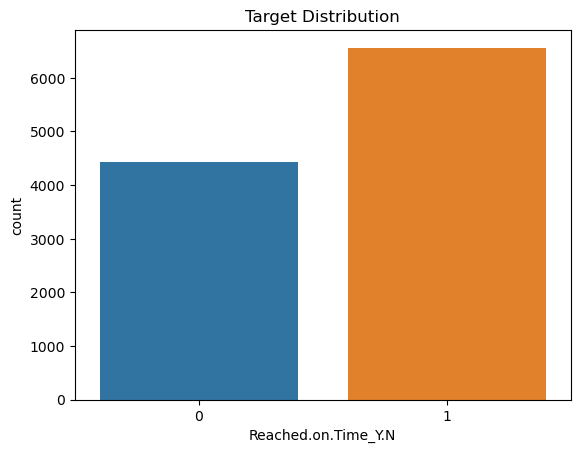

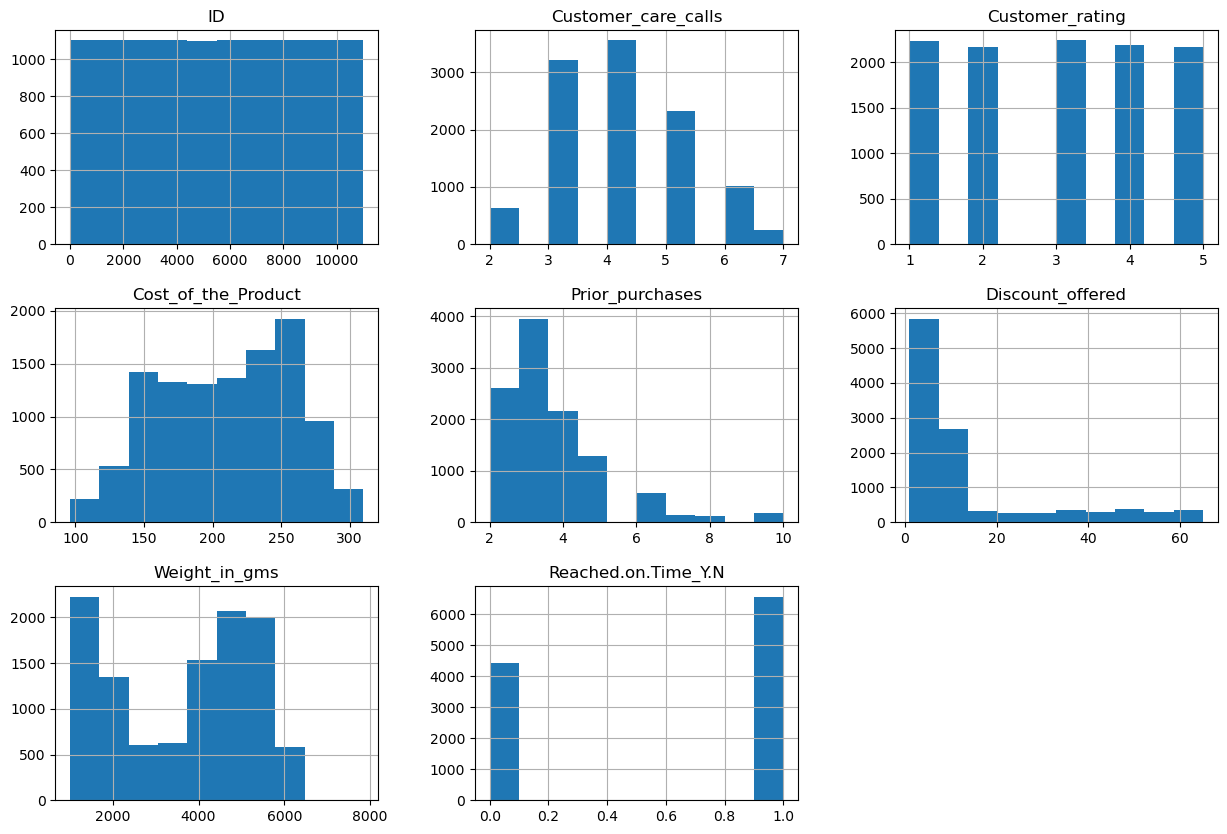

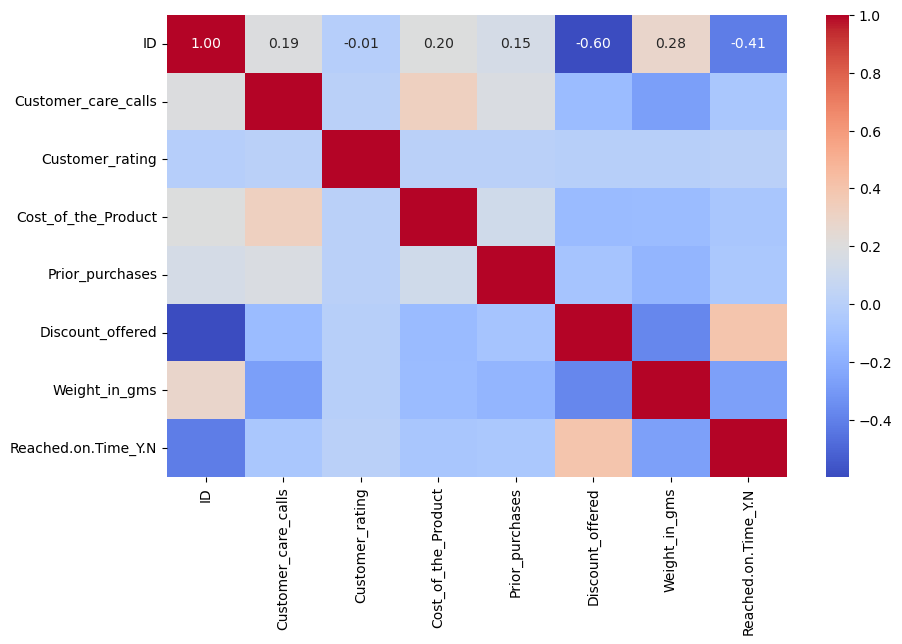

In [44]:
print(df.info())
print(df.isnull().sum())

# Target distribution
sns.countplot(x='Reached.on.Time_Y.N', data=df)
plt.title("Target Distribution")
plt.show()

# Numeric distribution
df.hist(figsize=(15,10))
plt.show()

# Correlation heatmap
plt.figure(figsize=(10,6))
sns.heatmap(df.select_dtypes(include=['number']).corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.show()

### Feature Preprocessing

We separate features (`X`) from the target (`y`), identify categorical and numerical columns, and create a `ColumnTransformer` for scaling and encoding.

In [45]:
X = df.drop(columns=['Reached.on.Time_Y.N', 'ID'])
y = df['Reached.on.Time_Y.N']

# Identify categorical & numerical columns
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numerical_features = X.select_dtypes(exclude=['object']).columns.tolist()

print("Categorical:", categorical_features)
print("Numerical:", numerical_features)

# Preprocessor
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

Categorical: ['Warehouse_block', 'Mode_of_Shipment', 'Product_importance', 'Gender']
Numerical: ['Customer_care_calls', 'Customer_rating', 'Cost_of_the_Product', 'Prior_purchases', 'Discount_offered', 'Weight_in_gms']


### Model Training & Selection

We train multiple models with **5-fold Stratified Cross-Validation** and compare their F1 scores.

Models:
- Logistic Regression
- Random Forest

- Gradient Boosting
- XGBoost

In [46]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(),
    "XGBoost": XGBClassifier(eval_metric='logloss', use_label_encoder=False)
}

results = []

for name, model in models.items():
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(pipe, X, y, cv=skf, scoring='f1')
    
    results.append({"Model": name, "F1 Mean": np.mean(scores), "F1 Std": np.std(scores)})

results_df = pd.DataFrame(results).sort_values(by="F1 Mean", ascending=False)
results_df


c:\Users\nghoo\AppData\Local\anaconda3\envs\e-commerce_env\lib\site-packages\xgboost\training.py:183: UserWarning: [21:50:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\nghoo\AppData\Local\anaconda3\envs\e-commerce_env\lib\site-packages\xgboost\training.py:183: UserWarning: [21:50:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\nghoo\AppData\Local\anaconda3\envs\e-commerce_env\lib\site-packages\xgboost\training.py:183: UserWarning: [21:50:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\nghoo\AppData\Local\anaconda3\envs\e-commerce_env\lib\site-packages\xgboost\training.py:183: UserWarning: [21:50:46] W

,Model,F1 Mean,F1 Std
3,XGBoost,0.693318,0.008213
0,Logistic Regression,0.690048,0.010711
1,Random Forest,0.689220,0.006372
2,Gradient Boosting,0.665456,0.010461


### Train Best Model on Full Data

We retrain the best-performing model on the full dataset and save it to the `models/` folder for backend usage.

In [47]:
best_model_name = results_df.iloc[0]["Model"]
print(f"Best Model: {best_model_name}")

best_model = models[best_model_name]

final_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', best_model)
])

final_pipe.fit(X, y)

os.makedirs("../models", exist_ok=True)
model_path = "../models/ecommerce_shipping_best_model.pkl"
joblib.dump(final_pipe, model_path)
print(f"Model saved to {model_path}")

c:\Users\nghoo\AppData\Local\anaconda3\envs\e-commerce_env\lib\site-packages\xgboost\training.py:183: UserWarning: [21:50:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best Model: XGBoost
Model saved to ../models/ecommerce_shipping_best_model.pkl


### Model Evaluation (Train/Test Split)

We evaluate the selected model using a separate train-test split and generate:
- Accuracy
- Classification Report

- Confusion Matrix
- ROC Curve


c:\Users\nghoo\AppData\Local\anaconda3\envs\e-commerce_env\lib\site-packages\xgboost\training.py:183: UserWarning: [21:50:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.6536363636363637

Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.67      0.61       887
           1       0.74      0.64      0.69      1313

    accuracy                           0.65      2200
   macro avg       0.65      0.66      0.65      2200
weighted avg       0.67      0.65      0.66      2200


Confusion Matrix:
 [[593 294]
 [468 845]]


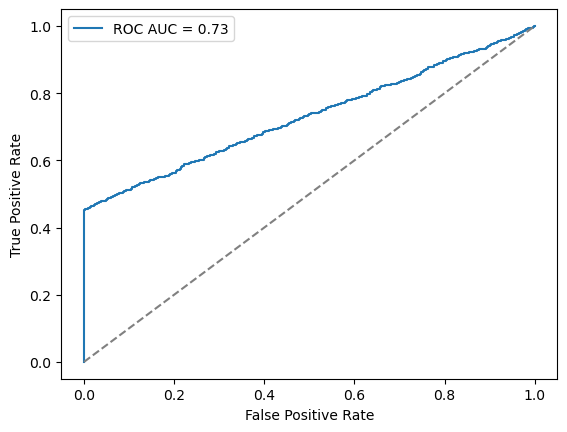

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

final_pipe.fit(X_train, y_train)
y_pred = final_pipe.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

# ROC Curve
y_pred_proba = final_pipe.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc_score(y_test, y_pred_proba):.2f}")
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

### Learning Curve

c:\Users\nghoo\AppData\Local\anaconda3\envs\e-commerce_env\lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
7 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
7 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\nghoo\AppData\Local\anaconda3\envs\e-commerce_env\lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\nghoo\AppData\Local\anaconda3\envs\e-commerce_env\lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\nghoo\AppData\Local\anaconda3\envs\e-commerce_env\li

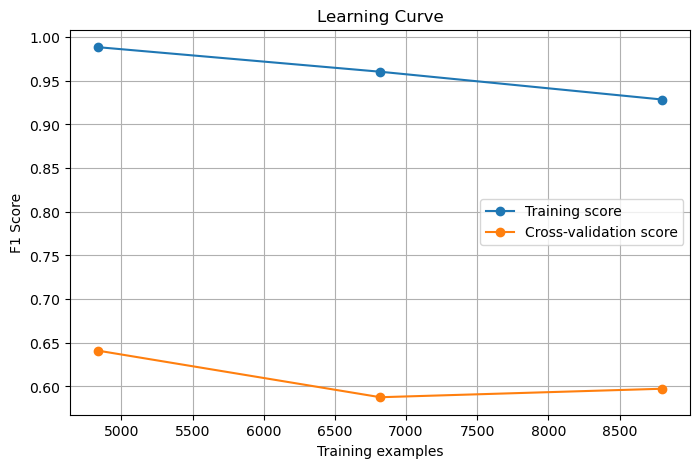

In [49]:
def plot_learning_curve(estimator, X, y, title="Learning Curve"):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=5, scoring='f1', n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 5), random_state=42
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.figure(figsize=(8,5))
    plt.plot(train_sizes, train_scores_mean, 'o-', label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', label="Cross-validation score")
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("F1 Score")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

plot_learning_curve(final_pipe, X, y)

### Feature Importance

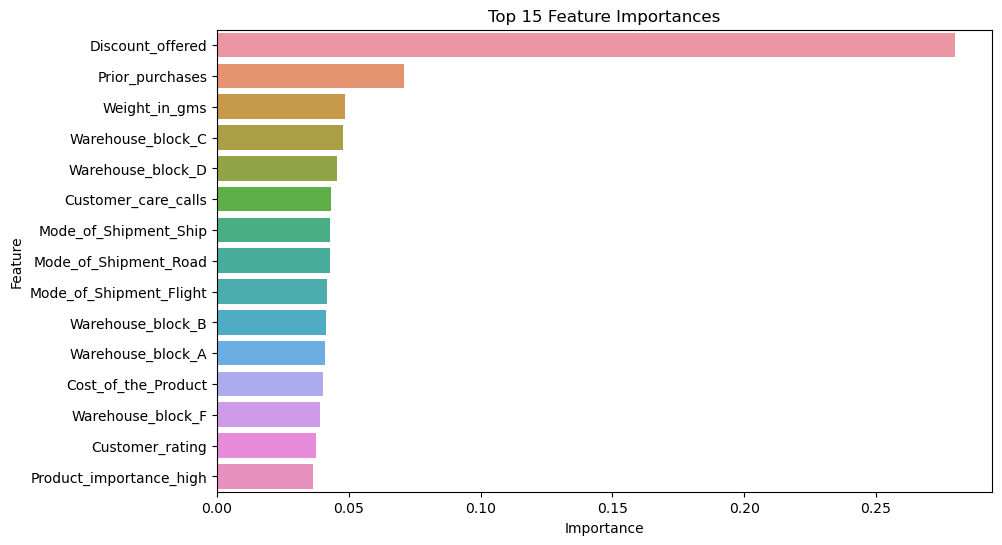

In [50]:
if hasattr(best_model, "feature_importances_"):
    # Lấy tên feature sau khi OneHotEncoder
    ohe_features = final_pipe.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_features)
    all_features = numerical_features + list(ohe_features)

    importances = best_model.feature_importances_
    feat_imp = pd.DataFrame({"Feature": all_features, "Importance": importances})
    feat_imp.sort_values(by="Importance", ascending=False, inplace=True)

    plt.figure(figsize=(10,6))
    sns.barplot(x="Importance", y="Feature", data=feat_imp.head(15))
    plt.title("Top 15 Feature Importances")
    plt.show()

### SHAP values

 99%|===================| 10863/10999 [00:26<00:00]        

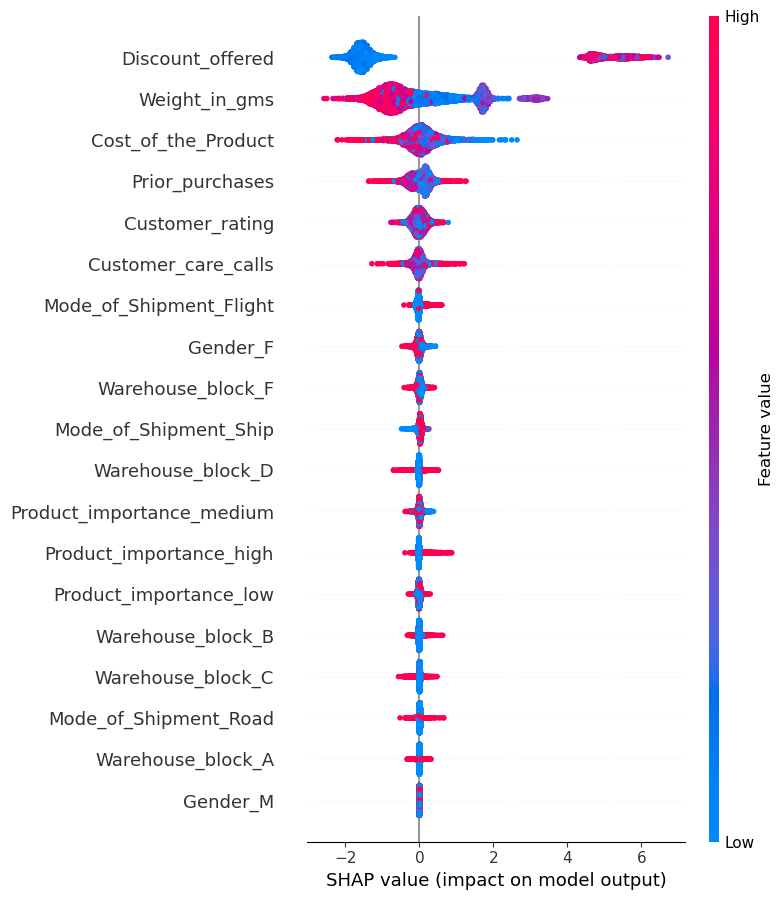

In [51]:
X_transformed = final_pipe.named_steps['preprocessor'].transform(X)

ohe = final_pipe.named_steps['preprocessor'].named_transformers_['cat']
ohe_feature_names = ohe.get_feature_names_out(final_pipe.named_steps['preprocessor'].transformers_[1][2])
feature_names = numerical_features + list(ohe_feature_names)

explainer = shap.Explainer(final_pipe.named_steps['model'], X_transformed)
shap_values = explainer(X_transformed)

shap.summary_plot(shap_values, features=X_transformed, feature_names=feature_names)

### Precision-Recall Curve

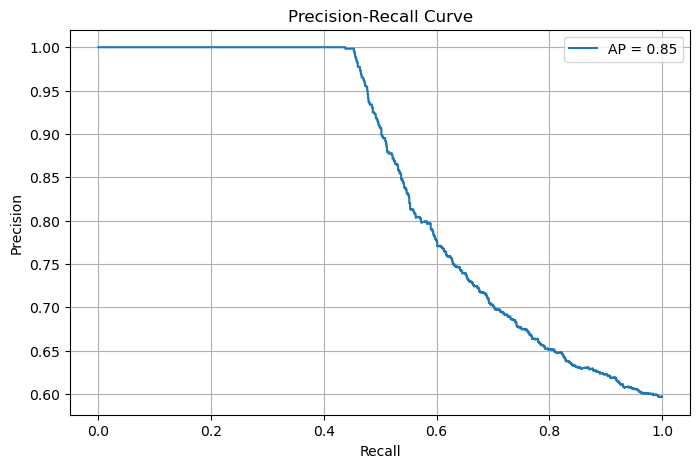

In [52]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
ap = average_precision_score(y_test, y_pred_proba)

plt.figure(figsize=(8,5))
plt.plot(recall, precision, label=f'AP = {ap:.2f}')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid()
plt.show()